Code from https://habr.com/ru/company/piter/blog/491268/
for 1 dimensional case

In [1]:
import numpy as np
import matplotlib.pyplot as plt

we will use standard normal distribution N(0,1), here is the log of it's density function

In [2]:
def log_prob(x):
     return -0.5 * np.sum(x ** 2)

we define the stepsize 

In [3]:
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize, 
                             high=x + 0.5 * stepsize, 
                             size=x.shape)

here we define the acceptance probability, using the symmetry of N(0,1)and the property of exponent function: exp(a)/exp(b)=exp(a-b)

In [4]:
def p_acc_MH(x_new, x_old, log_prob):
    return min(1, np.exp(  log_prob(x_new) - log_prob(x_old)))

sampling in MH-algorithm; 
also we return the acceptance decision

In [5]:
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    # here we determine whether the new state is accepted or not:
    # we uniformly select a random number from [0,1] and compare
    # its with the probability of successful acception
    accept = np.random.random() < p_acc_MH(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

Markov chain construction (with n_total steps)

In [6]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept
    
    acceptance_rate = n_accepted / float(n_total)
    
    return chain, acceptance_rate


In [7]:
chain, acceptance_rate = build_MH_chain(np.array([2.0]), 3.0, 10000, log_prob)
chain = [state for state, in chain]
print("Acceptance rate: {:.3f}".format(acceptance_rate))
last_states = ", ".join("{:.5f}".format(state) 
                        for state in chain[-10:])
print("Last ten states of chain: " + last_states)

Acceptance rate: 0.712
Last ten states of chain: 1.52075, 1.52075, 0.18440, -0.64727, 0.77881, -0.29834, -0.29834, -0.28485, -0.28485, 0.08996


Check how close are we with this Markov chain

In [5]:
def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad
    
    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # calculating the normalization constant of our PDF
    # scipy.integrate.quad compute the a definite integral
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)
    
fig, ax = plt.subplots()
plot_samples(chain[500:], log_prob, ax)
#despine(ax)
ax.set_yticks(())
plt.show()

NameError: name 'plt' is not defined

What is affected by step size? It is a parameter of the auxiliary distribution q, which controls how large the random steps performed by the Markov chain will be. If the step size is too large, the trial states often end up in the tail of the distribution, where the probability values are low. The Metropolis-Hastings sampling mechanism discards most of these steps, resulting in slower acceptance rates and significantly slower convergence

Acceptance rate: 0.105


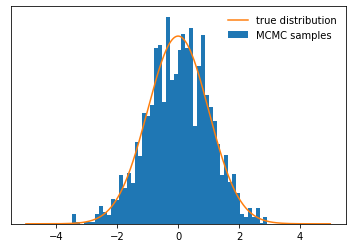

In [9]:
def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    #despine(ax)
    ax.set_yticks(())
    plt.show()
    
sample_and_display(np.array([2.0]), 30, 10000, 500, log_prob)

what if step size will be small? The Markov chain will examine the probability distribution very slowly, and therefore also will not converge as quickly as with a proper step size

Acceptance rate: 0.995


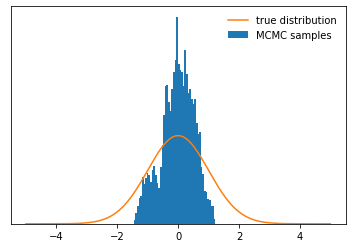

In [10]:
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)

No matter how you choose the step size parameter, the Markov chain will eventually converge to a stationary distribution. But this may take a long time. The time during which we will simulate the Markov chain is set by the n_total parameter. It simply determines how many states of the Markov chain (and, therefore, the selected samples) we will have. If the chain converges slowly, then you need to increase n_total so that the Markov chain has time to "forget" the original state

Acceptance rate: 0.990


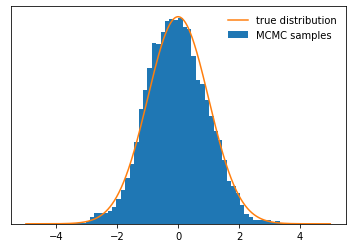

In [11]:
sample_and_display(np.array([2.0]), 0.1, 500000, 500, log_prob)